# VQA model accuracy

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import re, sys
import os
import copy
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load VizWiz test set data**

In [2]:
with open('/media/arnau/PEN/TFG/hf_model_test_res.json', encoding='UTF-8') as jf:
    model_output_data = json.load(jf)

## PromptCap accuracy
PromptCap model accuracy evaluated on VizWiz test set

In [3]:
import torch
from promptcap import PromptCap

model = PromptCap("vqascore/promptcap-coco-vqa")  # also support OFA checkpoints. e.g. "OFA-Sys/ofa-large"

if torch.cuda.is_available():
    model.cuda()

vqascore/promptcap-coco-vqa
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Helper functions

In [4]:
def remove_periods(q):
    
    outText = q
    puncts = [';', r"/", '[', ']', '"', '{', '}',
                                 '(', ')', '=', '+', '\\', '_', '-',
                                 '>', '<', '@', '`', ',', '?', '!']
    comma_strip = re.compile("(\d)(\,)(\d)")
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    for p in puncts:
        if (p + ' ' in q or ' ' + p in q) or (re.search(comma_strip, q) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            outText = periodStrip.sub("",
                                           outText,
                                           re.UNICODE)
    return outText

In [5]:


def num_words_to_digit(q):
    
    outText = []
    tempText = q.lower().split()
    manualMap  = { 'none': '0',
                    'zero': '0',
                    'one': '1',
                     'two': '2',
                     'three': '3',
                     'four': '4',
                     'five': '5',
                     'six': '6',
                     'seven': '7',
                     'eight': '8',
                     'nine': '9',
                     'ten': '10'}
    articles     = ['a',
                             'an',
                             'the'
                    ]
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                            "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                            "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                            "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                            "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                            "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                            "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                            "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                            "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                            "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                            "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                            "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                            "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                            "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                            "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                            "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                            "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                            "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                            "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                            "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                            "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                            "youll": "you'll", "youre": "you're", "youve": "you've"
                            }
    for word in tempText:
        word = manualMap.setdefault(word, word)
        if word not in articles:
            outText.append(word)
        else:
            pass

    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [6]:
def updateProgress(progress):
    
    barLength = 20
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rFinshed Percent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), int(progress*100), status)
    sys.stdout.write(text)
    sys.stdout.flush()

### Evaluation

In [7]:
def evaluate_acc_promptcap(model_output_data, model_type):

    accQA       = []
    step = 0
    
    data = model_output_data.copy()
    
    for img, img_info in data.items():
        question = img_info["question"]
        gtanswers = img_info["gt_answers"]
        for ans in gtanswers:
            if type(ans['answer']) == str:
                ans['answer'] = ans['answer'].replace('\n', ' ').replace('\t', ' ').strip().lower()
            else:
                ans['answer'] = ' '.join(ans['answer'])
        resAns = img_info[model_type]
        if resAns:
            resAns = resAns.replace('\n', ' ')
            resAns = resAns.replace('\t', ' ')
            resAns = resAns.strip()
            resAns = resAns.lower()
        else:
            resAns = ''
        gtAcc = []
        gtAnswers = [ans["answer"] for ans in gtanswers]

        if len(set(gtAnswers)) > 1:
            for ans in gtanswers:
                if type(ans['answer']) == str:
                    ans["answer"] = remove_periods(ans['answer'])
                    ans["answer"] = num_words_to_digit(ans['answer'])
                else:
                    ans["answer"] = remove_periods(' '.join(ans['answer']))
                    ans["answer"] = num_words_to_digit(' '.join(ans['answer']))
            resAns = remove_periods(resAns)
            resAns = num_words_to_digit(resAns)

        for ans in gtanswers:
            # otherGTAns = [item for item in gtanswers if item!=ans]
            matchingAns = [ans for ans in gtanswers if ans['answer'] == resAns]
            acc = min(1, float(len(matchingAns))/3)
            gtAcc.append(acc)

        avgGTAcc = float(sum(gtAcc))/len(gtAcc)
        accQA.append(avgGTAcc)

        if step%100 == 0:
            updateProgress(step/float(len(data.keys())))
        step = step + 1
    
    return accQA


In [8]:
model_types = [
                "HF_OCR_google_answer",
                "HF_OCR_answer",
                "HF_NON_OCR_answer"
                ]
default_results = []
for typ in model_types:
    res = evaluate_acc_promptcap(model_output_data, typ)
    acc = (sum(res) / len(res)) * 100
    default_results.append((typ, acc))
    print(f"--> {typ}: {acc:.4f}%")

Finshed Percent: [###################-] 93% --> HF_OCR_google_answer: 8.6062%
Finshed Percent: [###################-] 93% --> HF_OCR_answer: 7.0159%
Finshed Percent: [###################-] 93% --> HF_NON_OCR_answer: 10.6330%


## PromptCap accuracy using Blur model

PromptCap accuracy evaluted on VizWiz test set with a prior filtering of blurred images using a custom blur detection model

In [9]:
def model_inference(model, img, device):
    
    trnsfm = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4275, 0.4184, 0.4037], [0.1419, 0.1179, 0.1273])
    ])
    }
    
    model.eval()
    
    if type(img) == str:
        test_path = '/media/arnau/PEN/TFG/val/'
        img_path = os.path.join(test_path, img)
        img = Image.open(img_path)

    img = trnsfm["val"](img)
    img = img[None, :, :, :] 
    img = img.to(device)
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
    pred_res = predicted.cpu().detach().numpy().tolist()[0]
    
    return int(pred_res)


In [10]:
def initialize_model(num_classes=2):
    
    model = models.convnext_tiny(pretrained=True)
    model.fc = nn.Linear(512,num_classes)
        
    return model

In [11]:
# GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load custom blur model
save_path = '../outputs/best.pth'
model = initialize_model()
model.load_state_dict(torch.load(save_path))
model = model.to(device)

/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def evaluate_acc_promptcap_blur(model_output_data, model_type, model_params):

    accQA = []
    step = 0
    
    data = model_output_data.copy()
        
    for img, img_info in data.items():
        
        # Blur model filter
        model, device = model_params
        blur_detection = model_inference(model, img, device)
        if blur_detection == 0:
            
            question = img_info["question"]
            gtanswers = img_info["gt_answers"]
            for ans in gtanswers:
                if type(ans['answer']) == str:
                    ans['answer'] = ans['answer'].replace('\n', ' ').replace('\t', ' ').strip().lower()
                else:
                    ans['answer'] = ' '.join(ans['answer'])
            resAns = img_info[model_type]
            if resAns:
                resAns = resAns.replace('\n', ' ')
                resAns = resAns.replace('\t', ' ')
                resAns = resAns.strip()
                resAns = resAns.lower()
            else:
                resAns = ''
            gtAcc = []
            gtAnswers = [ans["answer"] for ans in gtanswers]

            if len(set(gtAnswers)) > 1:
                for ans in gtanswers:
                    if type(ans['answer']) == str:
                        ans["answer"] = remove_periods(ans['answer'])
                        ans["answer"] = num_words_to_digit(ans['answer'])
                resAns = remove_periods(resAns)
                resAns = num_words_to_digit(resAns)

            for ans in gtanswers:
                # otherGTAns = [item for item in gtanswers if item!=ans]
                matchingAns = [ans for ans in gtanswers if ans['answer'] == resAns]
                acc = min(1, float(len(matchingAns))/3)
                gtAcc.append(acc)

            avgGTAcc = float(sum(gtAcc))/len(gtAcc)
            accQA.append(avgGTAcc)

            if step%100 == 0:
                updateProgress(step/float(len(data.keys())))
            step = step + 1
    
    return accQA



In [16]:
model_params = (model, device)
blur_results = []

for typ in model_types:
    res = evaluate_acc_promptcap_blur(model_output_data, typ, model_params)
    acc = (sum(res) / len(res)) * 100
    blur_results.append((typ, acc)
    print(f"--> {typ}: {acc:.4f}%")

Finshed Percent: [#########-----------] 46% --> HF_OCR_google_answer: 9.7294%
Finshed Percent: [#########-----------] 46% --> HF_OCR_answer: 8.0023%
Finshed Percent: [#########-----------] 46% --> HF_NON_OCR_answer: 11.1111%


**Visualization** 

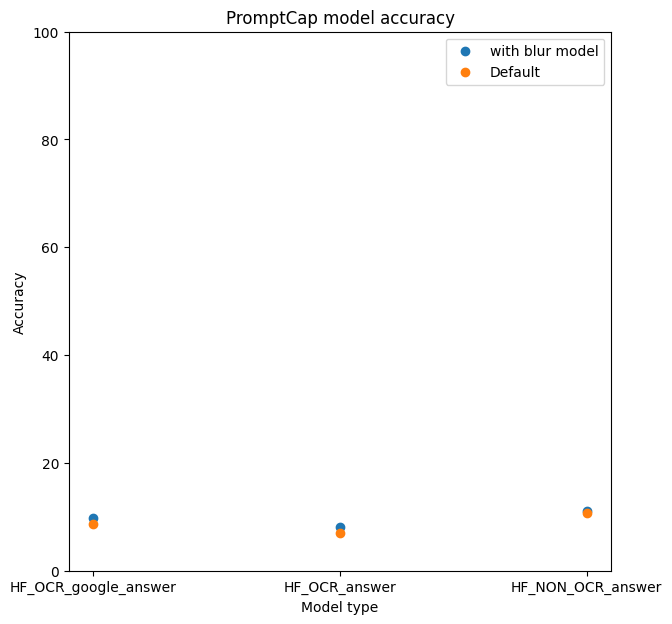

In [45]:
plt.figure(figsize=(7, 7))
plt.scatter(list(np.asarray(blur_results)[:, 0]), np.array(np.asarray(blur_results)[:, 1], dtype=np.float32), label="with blur model")
plt.scatter(list(np.asarray(default_results)[:, 0]), np.array(np.asarray(default_results)[:, 1], dtype=np.float32), label="Default")
plt.ylim([0, 100])
plt.title("PromptCap model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model type")
plt.legend()
plt.show()